# Cannabis Deforestation Spike - using NAIP imagery

In [1]:
import torch
from torchgeo.datasets import NAIP, GeoDataset, IntersectionDataset
from torch.utils.data import DataLoader
from torchgeo.samplers import RandomGeoSampler
from torchgeo.models import ResNet50_Weights, resnet50

import fastai.vision.all as fv

from fastai_torchgeo.data import GeoImageBlock
from fastai_torchgeo.resnet import make_resnet_model, resnet_split

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: mps


In [3]:
batch_size=64
num_workers = fv.defaults.cpus
dset_name = 'NAIP'

# Creating NAIP images for Urgency Ordinance permitted parcels

We need to create distinct images at each Urgency Ordinance permitted parcel. In order to do that, we take the union of the NAIP images and the UO parcels. We then do the same with the non-UO parcels.

In [19]:
from torchgeo.datasets import NAIP, VectorDataset
from torchgeo.datasets.utils import BoundingBox

# Load NAIP dataset
naip_path = "data-to-import/usgs/naip"
naip_dataset = NAIP(paths=naip_path)

class ShapefileDataset(VectorDataset):
    filename_glob = "*.shp"  # This assumes your shapefiles have a .shp extension

# Create the cannabis dataset
cannabis_ds = ShapefileDataset(paths=["cannabis-parcels/cannabis-registry-2018-commercial-apns.shp"])

# Create the intersection of NAIP and cannabis parcels
combined_ds = naip_dataset & cannabis_ds

Converting ShapefileDataset CRS from EPSG:4326 to EPSG:26910
Converting ShapefileDataset res from 0.0001 to 0.6


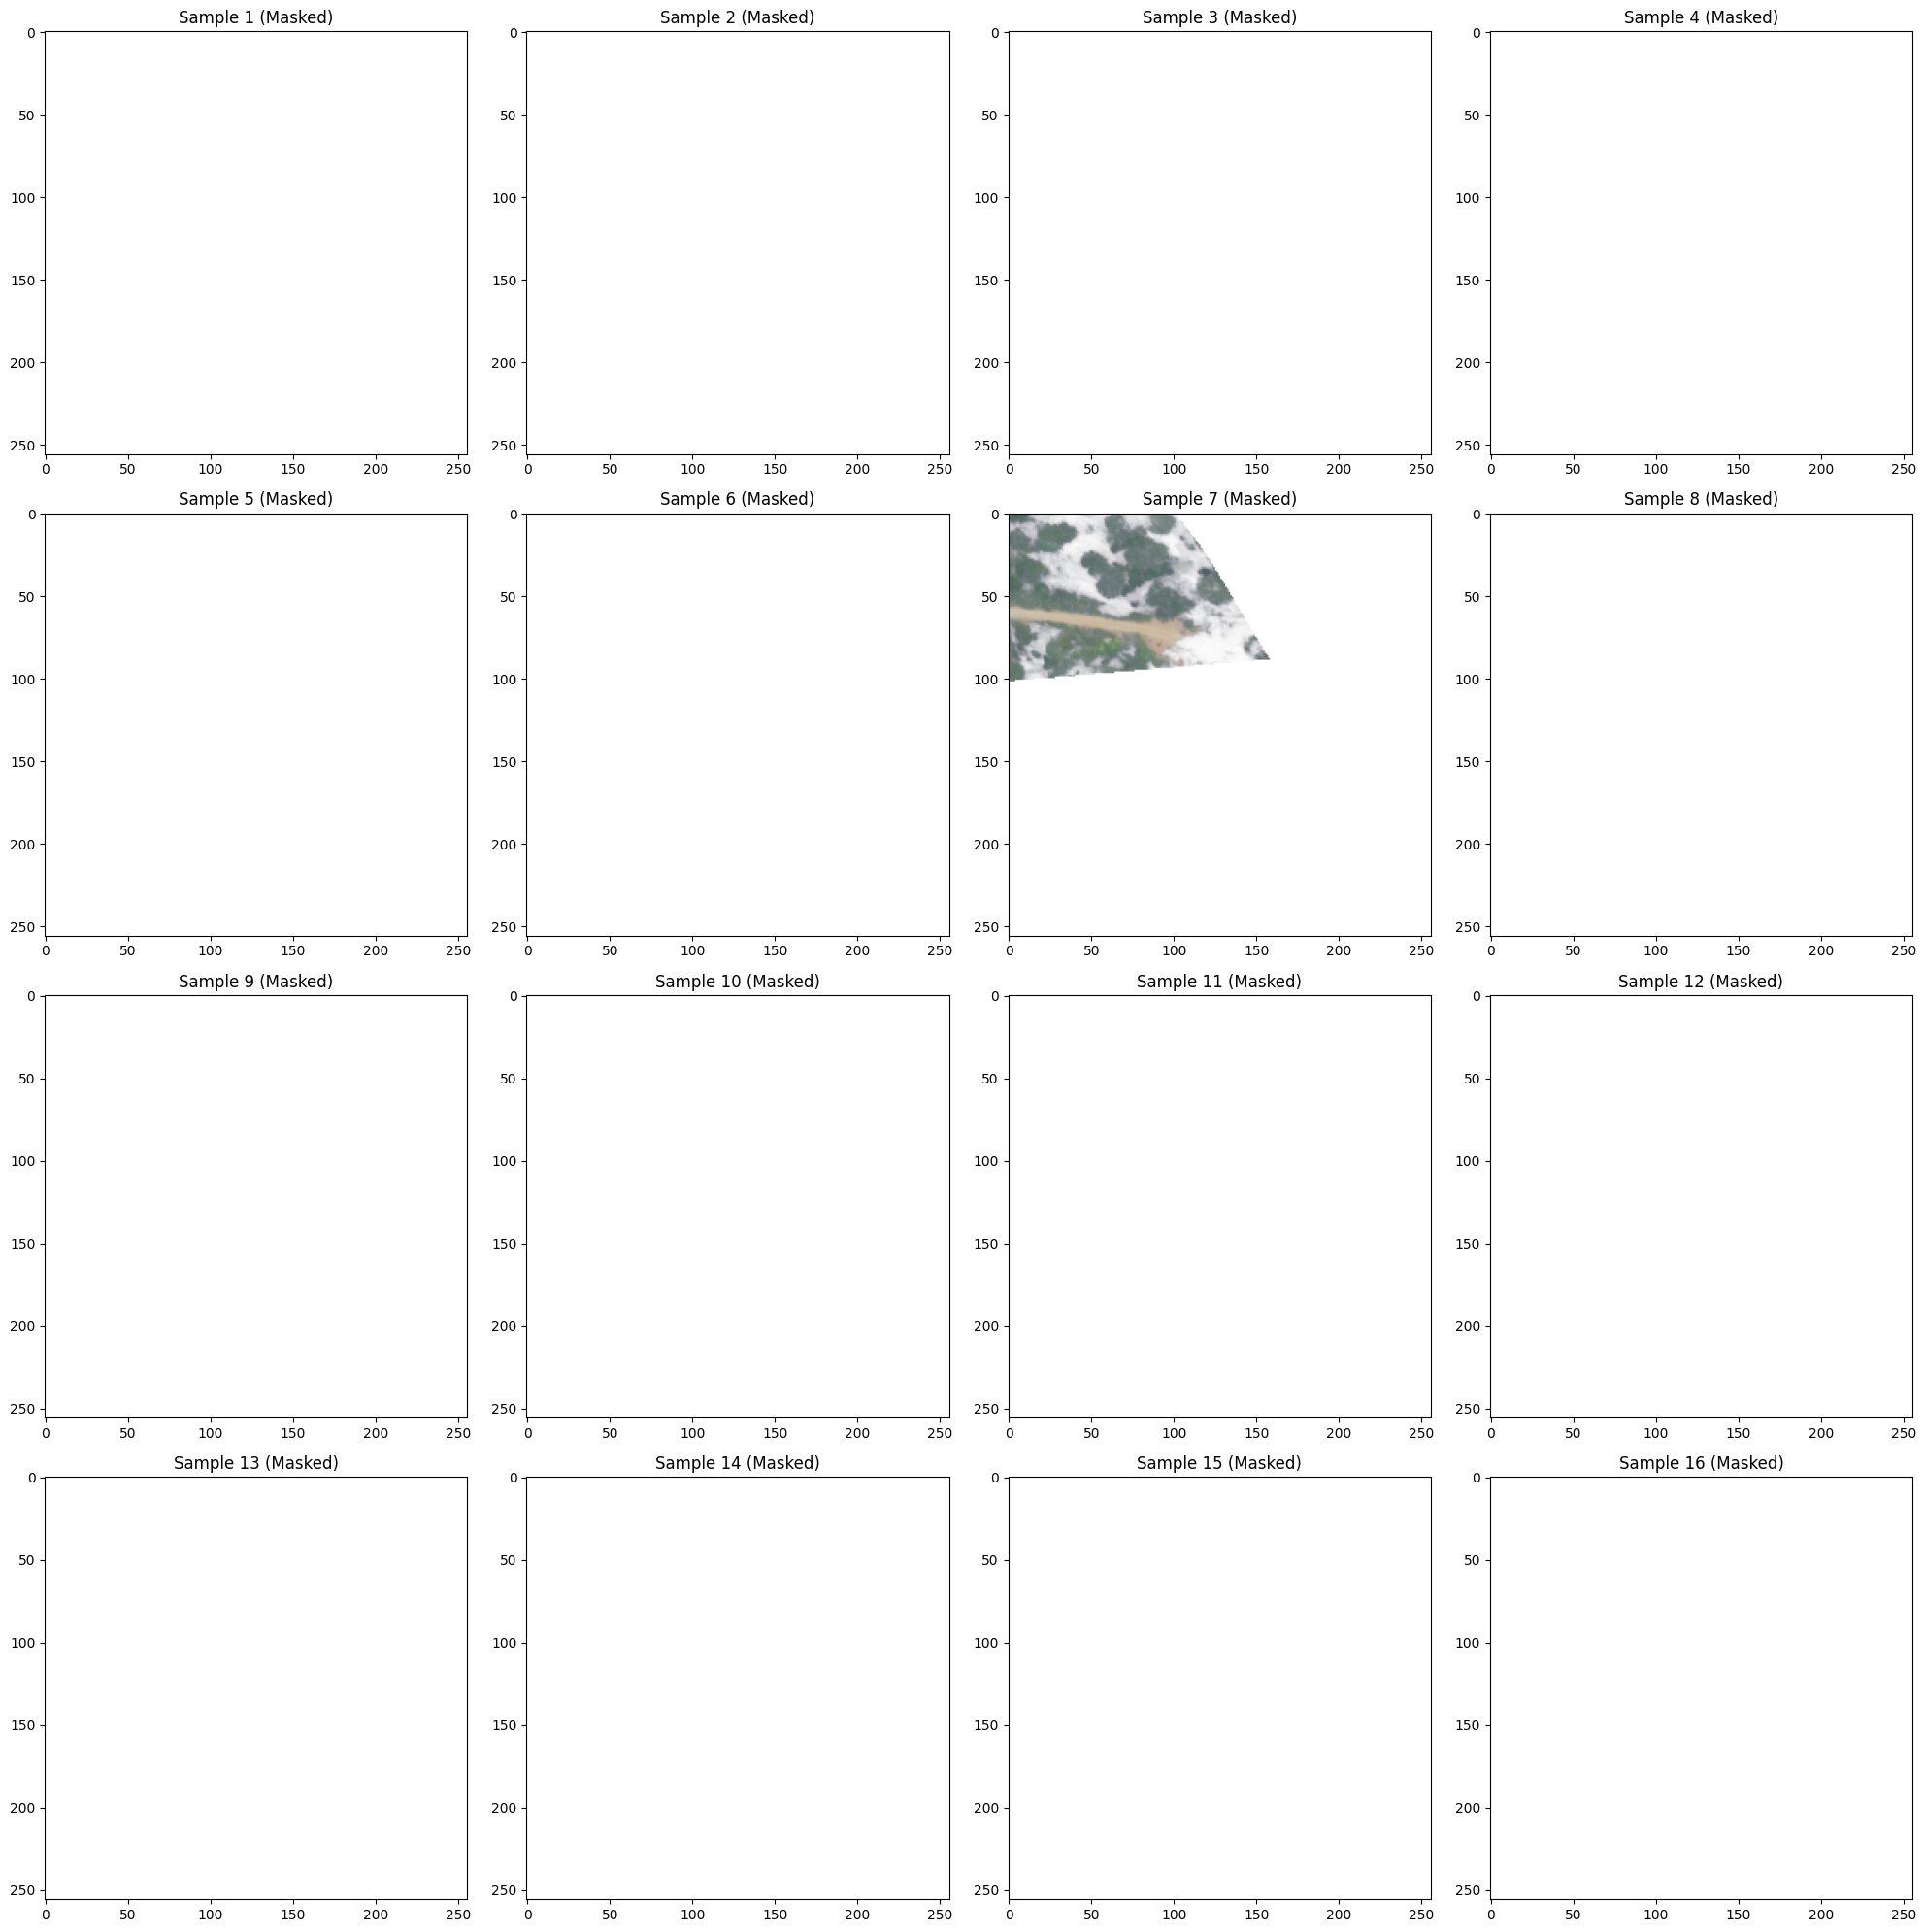

In [58]:
import matplotlib.pyplot as plt
from torchgeo.samplers import RandomGeoSampler

num_samples = 16
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.ravel()

sampler = RandomGeoSampler(combined_ds, size=(256, 256), length=num_samples)

for i, query in enumerate(sampler):
    sample = combined_ds[query]
    
    # Check if the sample contains valid image data
    if 'image' in sample:
        image = sample['image']
        # Ensure the image is in the correct format for plotting
        if image.ndim == 3 and image.shape[0] in [3, 4]:  # Check for RGB or RGBA
            image = image.float() / 255.0
            
            # Check if the sample contains a mask
            if 'mask' in sample:
                mask = sample['mask']
                # Ensure the mask is in the correct format for plotting
                if mask.ndim == 2:  # Assuming mask is 2D
                    # Apply the mask to the image
                    masked_image = image * mask.unsqueeze(0)  # Broadcast mask to match image channels
                    axs[i].imshow(masked_image.permute(1, 2, 0))
                    axs[i].set_title(f"Sample {i+1} (Masked)")
                else:
                    print(f"Sample {i+1} mask has unexpected shape: {mask.shape}")
            else:
                print(f"Sample {i+1} does not contain 'mask' key")
        else:
            print(f"Sample {i+1} has unexpected shape: {image.shape}")
    else:
        print(f"Sample {i+1} does not contain 'image' key")

    # Plot the NAIP image
    # naip_dataset.plot(sample, show_titles=True, suptitle=f"Sample {i+1}")
    # axs[i].imshow(sample['image'].permute(1, 2, 0), vmin=0, vmax=255)
    # axs[i].set_title(f"Sample {i+1}")
    
    # Optionally, you can overlay the cannabis parcel mask
    # mask = sample['mask']
    # axs[i].imshow(mask.squeeze())

plt.tight_layout()
plt.show()


In [36]:
# Define mean and std for NAIP imagery normalization (4 bands: R,G,B,NIR)
naip_mean = [0.485, 0.456, 0.406, 0.5]  # RGB + NIR means
naip_std = [0.229, 0.224, 0.225, 0.25]   # RGB + NIR standard deviations

# Modify the DataBlock to handle NAIP data properly
dblock = fv.DataBlock(
    blocks=(GeoImageBlock(n_channels=4), fv.CategoryBlock()),  # Specify 4 channels for NAIP
    get_items=lambda p: fv.get_image_files(p, folders=['uo-parcel', 'non-uo-parcel']),  # Specify your class folders
    splitter=fv.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=fv.parent_label,
    item_tfms=[fv.Resize(64)],
    batch_tfms=[fv.Normalize.from_stats(naip_mean, naip_std)]
)

dls = dblock.dataloaders('data-to-import/usgs/naip', batch_size=batch_size, num_workers=num_workers)

In [41]:
# Create the dataset
naip_path = 'data-to-import/usgs/naip'
naip_dataset = NAIP(paths=naip_path)

# Create train/val splits
train_size = int(0.8 * len(naip_dataset))
val_size = len(naip_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    naip_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# Convert to fastai DataLoaders if needed
dls = fv.DataLoaders(train_dataloader, val_dataloader, device=device)

In [43]:
dblock.summary(naip_path, show_batch=True)

Setting-up type transforms pipelines
Found 4 items
2 datasets of sizes 4,0
Setting up Pipeline: partial
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      data-to-import/usgs/naip/m_3812044_ne_10_060_20180725.tif
    applying partial gives
      GeoTensorImage of size 4x12320x9920
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      data-to-import/usgs/naip/m_3812044_ne_10_060_20180725.tif
    applying parent_label gives
      naip
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (GeoTensorImage: torch.Size([4, 12320, 9920]), TensorCategory(0))


Found 4 items
2 datasets of sizes 4,0
Setting up Pipeline: partial
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize 

RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `GeoTensorImage`:
	Item at index 0 has shape: torch.Size([4, 12320, 9920])
	Item at index 1 has shape: torch.Size([4, 12330, 9930])

Please include a transform in `after_item` that ensures all data of type GeoTensorImage is the same size